# Assignment 9: GBDT

#### Response Coding: Example

<img src='http://i.imgur.com/TufZptV.jpg' width=700px>

> The response tabel is built only on train dataset.
> For a category which is not there in train data and present in test data, we will encode them with default values
Ex: in our test data if have State: D then we encode it as [0.5, 0.05]

<ol>
    <li><strong>Apply GBDT on these feature sets</strong>
        <ul>
            <li><font color='red'>Set 1</font>: categorical(instead of one hot encoding, try <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/'>response coding</a>: use probability values), numerical features + project_title(TFIDF)+  preprocessed_eassay (TFIDF)+sentiment Score of eassay(check the bellow example, include all 4 values as 4 features)</li>
            <li><font color='red'>Set 2</font>: categorical(instead of one hot encoding, try <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/'>response coding</a>: use probability values), numerical features + project_title(TFIDF W2V)+  preprocessed_eassay (TFIDF W2V)</li>        
    </li>
    <li> Here in response encoding you need to apply the <strong>laplase smoothing</strong> value for test set. Laplase smoothing means, If test point is present in test but not in train then you need to apply default 0.5 as probability value for that data point (Refer the Response Encoding Image from above cell) </li>
    <li>Please use atleast <strong> 35k </strong> data points </li></ul>
    <li><strong>The hyper paramter tuning (Consider any two hyper parameters)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>find the best hyper paramter using k-fold cross validation/simple cross validation data</li>
    <li>use gridsearch cv or randomsearch cv or you can write your own for loops to do this task</li>
        </ul>
    </li>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/Gp2DQmh.jpg' width=500px> with X-axis as <strong>n_estimators</strong>, Y-axis as <strong>max_depth</strong>, and Z-axis as <strong>AUC Score</strong> , we have given the notebook which explains how to plot this 3d plot, you can find it in the same drive <i>3d_scatter_plot.ipynb</i></li>
            <p style="text-align:center;font-size:30px;color:red;"><strong>or</strong></p> <br>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/fgN9aUP.jpg' width=300px> <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heat maps</a> with rows as <strong>n_estimators</strong>, columns as <strong>max_depth</strong>, and values inside the cell representing <strong>AUC Score</strong> </li>
    <li>You choose either of the plotting techniques out of 3d plot or heat map</li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
        Make sure that you are using predict_proba method to calculate AUC curves, because AUC is calcualted on class probabilities and not on class labels.
    <img src='https://i.imgur.com/wMQDTFe.jpg' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='https://i.imgur.com/IdN5Ctv.png' width=300px></li>
            </ul>
    <br>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format
        <img src='http://i.imgur.com/YVpIGGE.jpg' width=400px>
    </li>
</ol>

# Few Notes

1. Use atleast 35k data points
2. Use classifier.Predict_proba() method instead of predict() method while calculating roc_auc scores
3. Be sure that you are using laplase smoothing in response encoding function. Laplase smoothing means applying the default (0.5) value to test data if the test data is not present in the train set


In [10]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/

import pickle
from tqdm import tqdm
import os

from collections import Counter
import math

In [11]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [12]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

sample_sentence_1='I am happy.'
ss_1 = sid.polarity_scores(sample_sentence_1)
print('sentiment score for sentence 1',ss_1)

sample_sentence_2='I am sad.'
ss_2 = sid.polarity_scores(sample_sentence_2)
print('sentiment score for sentence 2',ss_2)

sample_sentence_3='I am going to New Delhi tommorow.'
ss_3 = sid.polarity_scores(sample_sentence_3)
print('sentiment score for sentence 3',ss_3)


sentiment score for sentence 1 {'neg': 0.0, 'neu': 0.213, 'pos': 0.787, 'compound': 0.5719}
sentiment score for sentence 2 {'neg': 0.756, 'neu': 0.244, 'pos': 0.0, 'compound': -0.4767}
sentiment score for sentence 3 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}


<h1>1. GBDT (xgboost/lightgbm) </h1>

## 1.1 Loading Data

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
import pandas
data = pandas.read_csv('/content/drive/MyDrive/Case Studies/Donor Choose/6_Donors_choose_NB/preprocessed_data.csv',nrows = 35000)

In [15]:
print(data.shape)

data.head(2)

(35000, 9)


,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03


In [16]:
def get_sentiment_scores(sentence):

  sid = SentimentIntensityAnalyzer()

  sentiment_score = []

  scores = sid.polarity_scores(sentence)
  
  sentiment_score.append(scores['neg'])
  sentiment_score.append(scores['neu'])
  sentiment_score.append(scores['pos'])
  sentiment_score.append(scores['compound'])
  
  return sentiment_score

In [17]:
%%time 

score_list = []

# it will take around 7 min to get the score of 35k points 
scores     = data.apply(lambda x:get_sentiment_scores(x["essay"]), axis = 1)

CPU times: user 6min 4s, sys: 1.89 s, total: 6min 6s
Wall time: 6min 22s


In [18]:
for lists in tqdm(scores):
  score_list.append(lists)

df = pd.DataFrame(score_list)
df.columns = ['negative','neutral','positive','compound']

frames = [data,df]

# https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html 

final_data = pd.concat(frames,axis = 1)

print(final_data.shape)
final_data.head(2)

100%|██████████| 35000/35000 [00:00<00:00, 1475368.49it/s]

(35000, 13)


,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price,negative,neutral,positive,compound
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05,0.013,0.783,0.205,0.9867
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03,0.072,0.680,0.248,0.9897


In [19]:
# 2. Split your data.

y = final_data['project_is_approved'].values

X = final_data.drop(['project_is_approved'], axis = 1)

print(y.shape,X.shape)
print(final_data.shape[1] - X.shape[1])

X.head(2)

(35000,) (35000, 12)
1


,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,clean_categories,clean_subcategories,essay,price,negative,neutral,positive,compound
0,ca,mrs,grades_prek_2,53,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05,0.013,0.783,0.205,0.9867
1,ut,ms,grades_3_5,4,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03,0.072,0.680,0.248,0.9897


<h2>1.2 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, stratify = y)

<h2> Make Data Model Ready: encoding numerical, categorical features</h2>

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range = (1, 3),max_features = 6000, min_df = 10)

vectorizer.fit(X_train['essay'].values)

X_train_essay_tfidf = vectorizer.transform(X_train['essay'].values)
X_test_essay_tfidf  = vectorizer.transform(X_test['essay'].values)

# we are converting a dictionary with word as a key, and the idf as a value

dictionary  = dict(zip(vectorizer.get_feature_names(), list(vectorizer.idf_)))
tfidf_words = set(dictionary.keys())

vectorizer.get_feature_names()[-5:]

['your donations', 'your generous', 'your generous donation', 'youth', 'zone']

In [22]:
def get_response_coding(feature,labels,dx,test = False):

  positive_label = [] 
  negative_label = []

  frame = pd.DataFrame({'feature_name':feature,'label':labels})
  # print( frame.head(3) )

  if test == False:

    total_size = frame.shape[0]
    dx = dict() # Initializing a dictionary that would hold the unique values of categorical features

    for data in frame['feature_name']:
  
      if data not in dx:
        dx[data] = 0

    print(" **---** Response Encoding the Test data **---** ")
    # so now we have all the unique values of feature stored in our dictionary dx, now we will store prob value inside it.

    for key,value in dx.items():

      positive_class = frame[( frame['feature_name'] == key ) & (frame['label'] == 1) ] 

      dx[key] = positive_class.shape[0] / total_size

    for data in frame['feature_name']:
    
      positive_label.append(dx[data])
      negative_label.append(1 - dx[data])
  
    print("\n Shape of the provided train data datframe is  ->",frame.shape[0])
    print("\n len of positive encoded feature of train data ->",len(positive_label))
    print("\n len of negative encoded feature of train data ->",len(negative_label),"\n")

    return [positive_label,negative_label,dx]

  else:
    
    print(" \n**---** Response Encoding the Test data **---** ")

    for data in frame['feature_name']:
      
      try:

        positive_label.append(dx[data])
        negative_label.append(1 - dx[data])
      
      except:

        positive_label.append(0.5) # if there are entries that were not present in the train data those won't be inside the dictionary
        negative_label.append(0.5) # hence assigining them equal probabililty of 0.5. This is also called laplace smoothing.

    print("\n Shape of  the provide     Test dataframe  is ->",frame.shape[0])
    print("\n len of positive encoded feature of test data ->",len(positive_label))
    print("\n len of negative encoded feature of test data ->",len(negative_label))

    return [positive_label,negative_label]

**teacher_prefix**

In [23]:
teacher_prefix_pos,teacher_prefix_neg,teacher_prefix_dict = get_response_coding(X_train['teacher_prefix'].values,y_train,
                                                                                dict(),False)
print("Teacher_prefix_dict --",teacher_prefix_dict)

teacher_prefix_pos_te,teacher_prefix_neg_te = get_response_coding(X_test['teacher_prefix'].values,y_test,
                                                            teacher_prefix_dict,True)

 **---** Response Encoding the Test data **---** 

 Shape of the provided train data datframe is  -> 23450

 len of positive encoded feature of train data -> 23450

 len of negative encoded feature of train data -> 23450 

Teacher_prefix_dict -- {'mrs': 0.4651599147121535, 'ms': 0.293773987206823, 'mr': 0.07194029850746268, 'teacher': 0.01556503198294243, 'dr': 8.528784648187633e-05}
 
**---** Response Encoding the Test data **---** 

 Shape of  the provide     Test dataframe  is -> 11550

 len of positive encoded feature of test data -> 11550

 len of negative encoded feature of test data -> 11550


**project_grade**

In [24]:
project_grade_pos,project_grade_neg,project_grade_dict = get_response_coding(X_train['project_grade_category'].values,y_train,
                                                                                dict(),False)

print(project_grade_dict)

project_grade_pos_te,project_grade_neg_te = get_response_coding(X_test['project_grade_category'].values,y_test,
                                                                                project_grade_dict,True)

 **---** Response Encoding the Test data **---** 

 Shape of the provided train data datframe is  -> 23450

 len of positive encoded feature of train data -> 23450

 len of negative encoded feature of train data -> 23450 

{'grades_prek_2': 0.36008528784648186, 'grades_3_5': 0.2886993603411514, 'grades_6_8': 0.12174840085287847, 'grades_9_12': 0.07599147121535181}
 
**---** Response Encoding the Test data **---** 

 Shape of  the provide     Test dataframe  is -> 11550

 len of positive encoded feature of test data -> 11550

 len of negative encoded feature of test data -> 11550


**clean_categories**

In [25]:
clean_categories_pos,clean_categories_neg,clean_categories_dict = get_response_coding(X_train['clean_categories'].values,
                                                                            y_train,dict(),False)

print(clean_categories_dict)

clean_categories_pos_te,clean_categories_neg_te = get_response_coding(X_test['clean_categories'].values,y_test,
                                                                                clean_categories_dict,True)

 **---** Response Encoding the Test data **---** 

 Shape of the provided train data datframe is  -> 23450

 len of positive encoded feature of train data -> 23450

 len of negative encoded feature of train data -> 23450 

{'math_science': 0.11215351812366738, 'literacy_language math_science': 0.11198294243070363, 'math_science literacy_language': 0.01901918976545842, 'specialneeds': 0.02443496801705757, 'health_sports': 0.132409381663113, 'music_arts': 0.03573560767590618, 'literacy_language': 0.17906183368869935, 'math_science specialneeds': 0.011641791044776119, 'appliedlearning literacy_language': 0.019189765458422176, 'appliedlearning specialneeds': 0.010788912579957356, 'history_civics': 0.012153518123667377, 'literacy_language specialneeds': 0.028912579957356077, 'history_civics literacy_language': 0.011343283582089553, 'appliedlearning': 0.02720682302771855, 'health_sports literacy_language': 0.00908315565031983, 'math_science music_arts': 0.007803837953091685, 'literacy_langua

**clean_subcategories**

In [26]:
clean_subcategories_pos,clean_subcategories_neg,clean_subcategories_dict = get_response_coding(X_train['clean_subcategories'].values,
                                                                            y_train,dict(),False)

print(clean_subcategories_dict)

clean_subcategories_pos_te,clean_subcategories_neg_te = get_response_coding(X_test['clean_subcategories'].values,y_test,
                                                                                clean_subcategories_dict,True)

 **---** Response Encoding the Test data **---** 

 Shape of the provided train data datframe is  -> 23450

 len of positive encoded feature of train data -> 23450

 len of negative encoded feature of train data -> 23450 

{'mathematics': 0.03646055437100213, 'literature_writing mathematics': 0.04759061833688699, 'health_lifescience literacy': 0.00349680170575693, 'environmentalscience mathematics': 0.004904051172707889, 'literacy mathematics': 0.06213219616204691, 'specialneeds': 0.02443496801705757, 'health_wellness': 0.0535181236673774, 'music performingarts': 0.007334754797441364, 'literature_writing': 0.03398720682302772, 'mathematics specialneeds': 0.007121535181236674, 'earlydevelopment literature_writing': 0.0018763326226012792, 'gym_fitness health_wellness': 0.03390191897654584, 'literacy': 0.06993603411513859, 'teamsports': 0.006439232409381663, 'earlydevelopment specialneeds': 0.0061833688699360345, 'gym_fitness': 0.013432835820895522, 'socialsciences': 0.001535181236673774,

**school_state**

In [27]:
school_state_pos,school_state_neg,school_state_dict = get_response_coding(X_train['school_state'].values,
                                                      y_train,dict(),False)

print(school_state_dict)

school_state_pos_te,school_state_neg_te = get_response_coding(X_test['school_state'].values,y_test,
                                                              school_state_dict,True)

 **---** Response Encoding the Test data **---** 

 Shape of the provided train data datframe is  -> 23450

 len of positive encoded feature of train data -> 23450

 len of negative encoded feature of train data -> 23450 

{'fl': 0.050106609808102345, 'tn': 0.01671641791044776, 'oh': 0.022686567164179106, 'ca': 0.11249466950959489, 'sd': 0.0026439232409381664, 'in': 0.022473347547974414, 'de': 0.003837953091684435, 'ok': 0.01859275053304904, 'mo': 0.021961620469083155, 'tx': 0.05906183368869936, 'pa': 0.025458422174840085, 'ga': 0.031769722814498934, 'mi': 0.025373134328358207, 'nc': 0.04626865671641791, 'ma': 0.01884861407249467, 'az': 0.01628997867803838, 'nj': 0.014072494669509595, 'ny': 0.0529637526652452, 'sc': 0.03275053304904051, 'va': 0.0167590618336887, 'wa': 0.01901918976545842, 'nd': 0.0011513859275053306, 'il': 0.035309168443496804, 'ms': 0.009168443496801706, 'mt': 0.0016631130063965885, 'md': 0.012921108742004264, 'vt': 0.0006396588486140725, 'mn': 0.008614072494669509, '

**price**

In [28]:
## Price ##

from sklearn.preprocessing import StandardScaler

sc = StandardScaler(copy = True,with_mean = True,with_std = True)
sc.fit(X_train['price'].values.reshape(-1,1))

X_train_price_norm  =  sc.transform(X_train['price'].values.reshape(-1,1))
X_test_price_norm   =  sc.transform(X_test['price'].values.reshape(-1,1))

print("Mean--",sc.mean_)
print("std --",np.sqrt(sc.var_))

print(X_train_price_norm.shape)
print(X_train_price_norm.shape)

print(type(X_train_price_norm),X_train_price_norm[0])

Mean-- [300.32251599]
std -- [336.23306133]
(23450, 1)
(23450, 1)
<class 'numpy.ndarray'> [-0.52755822]


**teacher_number_of_previously_posted_projects**

In [29]:
## teacher_number_of_previously_posted_projects ##

sc = StandardScaler(copy = True,with_mean = True,with_std = True)
sc.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

X_train_projects_posted_norm  =  sc.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_test_projects_posted_norm   =  sc.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

print("Mean--",sc.mean_)
print("std --",np.sqrt(sc.var_))

print(X_train_projects_posted_norm.shape)
print(X_train_projects_posted_norm.shape)

print(type(X_train_projects_posted_norm),X_train_projects_posted_norm[0])

Mean-- [9.96865672]
std -- [24.47992081]
(23450, 1)
(23450, 1)
<class 'numpy.ndarray'> [-0.36636788]


In [30]:
print(X_train_essay_tfidf.shape)
print(len(school_state_pos))


ps = np.array(school_state_pos)

print(ps.shape)
print(ps.reshape(-1,1).shape)

(23450, 6000)
23450
(23450,)
(23450, 1)


In [31]:
from scipy.sparse import  hstack

X_tr = hstack((
               X_train_essay_tfidf,
               np.array(school_state_pos).reshape(-1,1),np.array(school_state_neg).reshape(-1,1),
               np.array(project_grade_pos).reshape(-1,1),np.array(project_grade_neg).reshape(-1,1),
               np.array(clean_subcategories_pos).reshape(-1,1),np.array(clean_subcategories_neg).reshape(-1,1),
               np.array(clean_categories_pos).reshape(-1,1),np.array(clean_categories_neg).reshape(-1,1),
               X_train_price_norm,X_train_projects_posted_norm,
               X_train['negative'].values.reshape(-1,1),
               X_train['neutral'].values.reshape(-1,1),
               X_train['positive'].values.reshape(-1,1),
               X_train['compound'].values.reshape(-1,1)
               )).tocsr()

X_te = hstack((X_test_essay_tfidf,
               np.array(school_state_pos_te).reshape(-1,1),np.array(school_state_neg_te).reshape(-1,1),
               np.array(project_grade_pos_te).reshape(-1,1),np.array(project_grade_neg_te).reshape(-1,1),
               np.array(clean_subcategories_pos_te).reshape(-1,1),np.array(clean_subcategories_neg_te).reshape(-1,1),
               np.array(clean_categories_pos_te).reshape(-1,1),np.array(clean_categories_neg_te).reshape(-1,1),
               X_test_price_norm,X_test_projects_posted_norm,
               X_test['negative'].values.reshape(-1,1),
               X_test['neutral'].values.reshape(-1,1),
               X_test['positive'].values.reshape(-1,1),
               X_test['compound'].values.reshape(-1,1))).tocsr()

print("Final Data matrix")

print(X_tr.shape, y_train.shape)
print(X_te.shape, y_test.shape)

Final Data matrix
(23450, 6014) (23450,)
(11550, 6014) (11550,)


<h2>1.5 Appling Models on different kind of featurization as mentioned in the instructions</h2>

<br>Apply GBDT on different kind of featurization as mentioned in the instructions
<br> For Every model that you work on make sure you do the step 2 and step 3 of instrucations

In [34]:
%%time 

# as the number of hyperparameters are large in this case so we will use randomized search cv insetad og gridsearch 

from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

gbdt = XGBClassifier()

grid_params = {'n_estimators': [10,50,100], 'max_depth':[2,5,7,9,11]}
 
clf = RandomizedSearchCV(gbdt,grid_params ,cv = 2, scoring = 'roc_auc',n_jobs =-1,verbose = 2,return_train_score =  True)
clf.fit(X_tr, y_train)  

results = pd.DataFrame.from_dict(clf.cv_results_)

results.head(3)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
CPU times: user 2min 34s, sys: 858 ms, total: 2min 35s
Wall time: 12min 25s


In [35]:
print( results.columns )

results.head()

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_n_estimators', 'param_max_depth', 'params', 'split0_test_score',
       'split1_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score', 'split0_train_score', 'split1_train_score',
       'mean_train_score', 'std_train_score'],
      dtype='object')


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_max_depth,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,mean_train_score,std_train_score
0,48.379698,0.221841,1.134042,0.003731,50,7,"{'n_estimators': 50, 'max_depth': 7}",0.691183,0.685950,0.688566,0.002617,7,0.975335,0.972813,0.974074,0.001261
1,111.083958,0.216092,1.264294,0.010111,100,9,"{'n_estimators': 100, 'max_depth': 9}",0.702525,0.702379,0.702452,0.000073,2,0.999565,0.999219,0.999392,0.000173
2,26.404898,0.073880,1.119250,0.004157,100,2,"{'n_estimators': 100, 'max_depth': 2}",0.694618,0.683955,0.689287,0.005332,6,0.789475,0.793032,0.791253,0.001778
3,62.945967,0.059260,1.145352,0.011255,100,5,"{'n_estimators': 100, 'max_depth': 5}",0.705653,0.696823,0.701238,0.004415,3,0.962088,0.958619,0.960353,0.001734
4,10.043902,0.016174,1.070018,0.001910,10,7,"{'n_estimators': 10, 'max_depth': 7}",0.639138,0.626165,0.632651,0.006487,10,0.848989,0.832068,0.840529,0.008460


In [36]:
pivoted_results = results.pivot(index = 'param_n_estimators', columns = 'param_max_depth')

pivoted_results.head()

mean_fit_time                                    \
param_max_depth               2          5          7           9    
param_n_estimators                                                   
10                           NaN   7.480436  10.043902         NaN   
50                     13.913860        NaN  48.379698         NaN   
100                    26.404898  62.945967  86.565109  111.083958   

                               std_fit_time                                \
param_max_depth             11           2         5         7         9    
param_n_estimators                                                          
10                         NaN          NaN  0.007869  0.016174       NaN   
50                   69.409586      0.05941       NaN  0.221841       NaN   
100                 133.884407      0.07388  0.059260  0.009928  0.216092   

                              ... mean_train_score                      \
param_max_depth           11  ...               2         5         7    
param_n_estimators            ...                                        
10                       NaN  ...              NaN  0.774034  0.840529   
50                  0.397570  ...         0.739338       NaN  0.974074   
100                 0.049692  ...         0.791253  0.960353  0.993251   

                                       std_train_score                      \
param_max_depth           9         11              2         5         7    
param_n_estimators                                                           
10                       NaN       NaN             NaN  0.005745  0.008460   
50                       NaN  0.999129        0.002597       NaN  0.001261   
100                 0.999392  0.999945        0.001778  0.001734  0.000471   

                                        
param_max_depth           9         11  
param_n_estimators                      
10                       NaN       NaN  
50                       NaN  0.000464  
100                 0.000173  0.000026  

[3 rows x 70 columns]

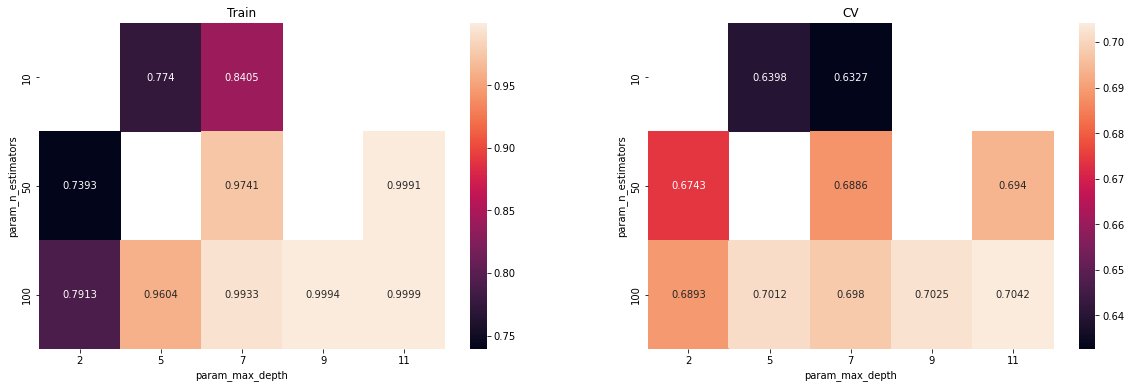

In [37]:
fig, ax = plt.subplots(1,2, figsize=(20,6))

sns.heatmap(pivoted_results.mean_train_score, annot = True, fmt='.4g',  ax = ax[0]) 
sns.heatmap(pivoted_results.mean_test_score,  annot = True, fmt='.4g',  ax = ax[1])

ax[0].set_title('Train')
ax[1].set_title('CV')

plt.show()

* Here we have white cells because we used randomizedsearchCV instead of gridsearch

In [38]:
print('Best ROC-AUC score: ',clf.best_score_)
print('Best Parameter are: ',clf.best_params_)

Best ROC-AUC score:  0.7042242521416702
Best Parameter are:  {'n_estimators': 100, 'max_depth': 11}


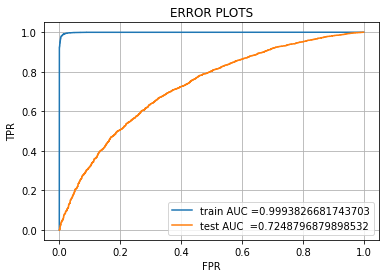

In [39]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc

gbdt = XGBClassifier(n_estimators = 100,max_depth = 5)
gbdt.fit(X_tr, y_train)

y_train_pred = gbdt.predict_proba(X_tr)[:,1]
y_test_pred  = gbdt.predict_proba(X_te)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr,  test_tpr, te_thresholds  = roc_curve(y_test,  y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr,   label="test AUC  ="+str(auc(test_fpr, test_tpr)))

plt.legend()

plt.xlabel("FPR")
plt.ylabel("TPR")

plt.title("ERROR PLOTS")

plt.grid()
plt.show()

* Here we can see clearly that our model is overfitting so we have to chose better hyperparameters to resolve the issue.

* let's start by fixing our max_depth = 5 , as we do not want very large depth trees in GBDT we need high biased models and we will try new hyperparameter called learning rate and see if that's work or not .

* here if learning rate increases then model overfits but if we reduce the learning rate then it increase both train and query time , and since here we want to avoid overfiting so we won't focus much on time part.

* https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

* https://www.kaggle.com/code/tilii7/hyperparameter-grid-search-with-xgboost/notebook


In [53]:
%%time 
# around 28 minutes

# as the number of hyperparameters are large in this case so we will use randomized search cv insetad of gridsearch
# we can also use bayesian optimization for xgboost if the hyperparameters increases  

from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

gbdt = XGBClassifier(max_depth = 5,random_state = 42)

grid_params = {'n_estimators': [100,200,300], 'learning_rate':[0.001, 0.01, 0.1, 0.2]}
 
clf = GridSearchCV(gbdt,grid_params ,cv = 2, scoring = 'roc_auc',n_jobs =-1,verbose = 3,return_train_score =  True)
clf.fit(X_tr, y_train)  

results = pd.DataFrame.from_dict(clf.cv_results_)

results.head(3)

Fitting 2 folds for each of 12 candidates, totalling 24 fits
CPU times: user 3min 27s, sys: 1.71 s, total: 3min 28s
Wall time: 28min 39s


In [54]:
results.head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_n_estimators,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,mean_train_score,std_train_score
0,66.002157,0.036836,1.122713,0.019463,0.001,100,"{'learning_rate': 0.001, 'n_estimators': 100}",0.607312,0.607091,0.607202,0.000111,12,0.657225,0.698363,0.677794,0.020569
1,125.028609,0.593334,1.248266,0.026512,0.001,200,"{'learning_rate': 0.001, 'n_estimators': 200}",0.622618,0.616906,0.619762,0.002856,11,0.700814,0.721759,0.711287,0.010473
2,187.230708,0.332532,1.289277,0.003098,0.001,300,"{'learning_rate': 0.001, 'n_estimators': 300}",0.628011,0.620328,0.624169,0.003842,10,0.714009,0.735917,0.724963,0.010954


In [55]:
pivoted_results = results.pivot(index = 'param_n_estimators', columns = 'param_learning_rate')

pivoted_results.head()

mean_fit_time                                      \
param_learning_rate         0.001       0.010       0.100       0.200   
param_n_estimators                                                      
100                     66.002157   63.304800   62.403324   61.969598   
200                    125.028609  125.569975  122.282912  122.386260   
300                    187.230708  189.632410  181.885287  182.735750   

                    std_fit_time                                \
param_learning_rate        0.001     0.010     0.100     0.200   
param_n_estimators                                               
100                     0.036836  0.110835  0.057692  0.085141   
200                     0.593334  0.471448  0.005726  0.393534   
300                     0.332532  0.622555  0.388691  0.339290   

                    mean_score_time            ... split1_train_score  \
param_learning_rate           0.001     0.010  ...              0.100   
param_n_estimators                             ...                      
100                        1.122713  1.125321  ...           0.958619   
200                        1.248266  1.249586  ...           0.989081   
300                        1.289277  1.408948  ...           0.997133   

                              mean_train_score                                \
param_learning_rate     0.200            0.001     0.010     0.100     0.200   
param_n_estimators                                                             
100                  0.988231         0.677794  0.787031  0.960353  0.987296   
200                  0.999157         0.711287  0.839799  0.989476  0.999106   
300                  0.999977         0.724963  0.874356  0.997543  0.999971   

                    std_train_score                                
param_learning_rate           0.001     0.010     0.100     0.200  
param_n_estimators                                                 
100                        0.020569  0.004261  0.001734  0.000936  
200                        0.010473  0.001679  0.000396  0.000051  
300                        0.010954  0.002486  0.000410  0.000006  

[3 rows x 56 columns]

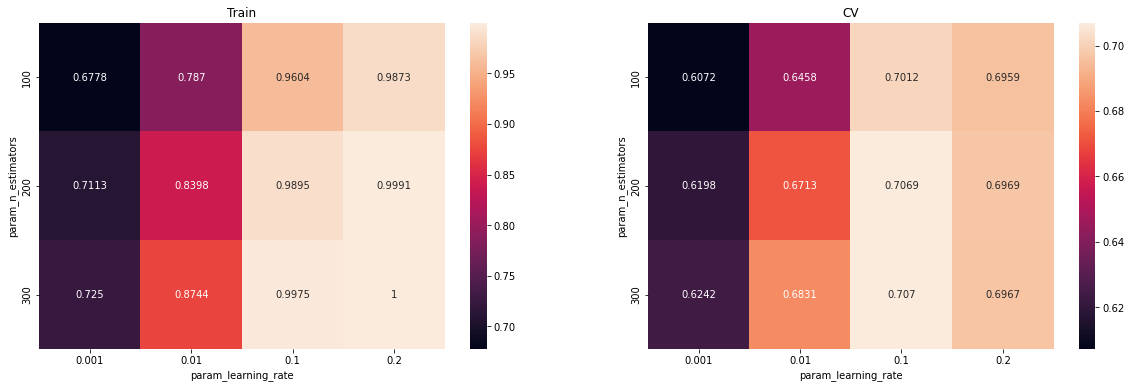

In [56]:
fig, ax = plt.subplots(1,2, figsize=(20,6))

sns.heatmap(pivoted_results.mean_train_score, annot = True, fmt='.4g',  ax = ax[0]) 
sns.heatmap(pivoted_results.mean_test_score,  annot = True, fmt='.4g',  ax = ax[1])

ax[0].set_title('Train')
ax[1].set_title('CV')

plt.show()

* here we can see that increasing the n_estimators also increasing the overfiting, so we will take minimum number of estimators which is giving the same performance on test data  


In [61]:
print('Best ROC-AUC score: ',clf.best_score_)
print('Best Parameter are: ',clf.best_params_)

Best ROC-AUC score:  0.7012380390122503
Best Parameter are:  {'learning_rate': 0.1, 'n_estimators': 100}


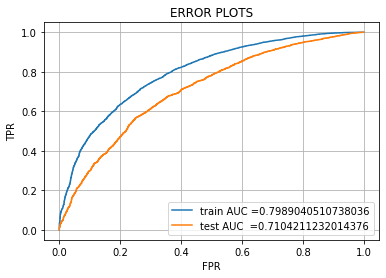

In [66]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc

gbdt = XGBClassifier(n_estimators = 100,max_depth = 3, learning_rate = 0.1,subsample = 0.5,colsample_bytree = 0.5)
gbdt.fit(X_tr, y_train)

y_train_pred = gbdt.predict_proba(X_tr)[:,1]
y_test_pred  = gbdt.predict_proba(X_te)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr,  test_tpr, te_thresholds  = roc_curve(y_test,  y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr,   label="test AUC  ="+str(auc(test_fpr, test_tpr)))

plt.legend()

plt.xlabel("FPR")
plt.ylabel("TPR")

plt.title("ERROR PLOTS")

plt.grid()
plt.show()

* we were able to reduce the overfiting significantly if we compare it with our previous models and moreover we were also able to increase the performance on the test data .

In [67]:
def find_best_threshold(threshold, fpr, tpr):
    t = threshold[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    
    return t

def predict_with_best_t(proba, threshold):
    predictions = []
    
    for i in proba:
        if i>= threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

from sklearn.metrics import confusion_matrix

best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)

the maximum value of tpr*(1-fpr) 0.5235934077311648 for threshold 0.836


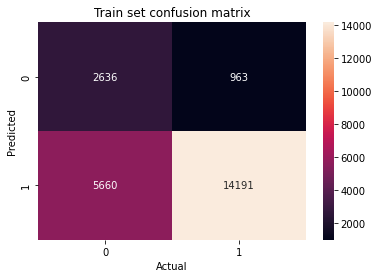

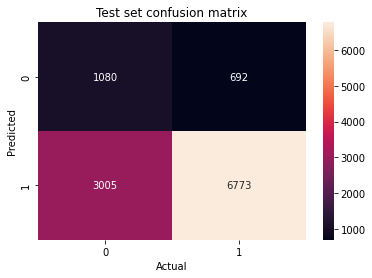

In [68]:
# Heatmap for train set confusion matrix()

heatmap_train = sns.heatmap(confusion_matrix(y_train, predict_with_best_t(y_train_pred,best_t)), annot = True, fmt = "d")

plt.title("Train set confusion matrix")

plt.xlabel("Actual")
plt.ylabel("Predicted")

plt.show()

# Heatmap for test set confusion matrix()

heatmap_test = sns.heatmap(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)), annot = True, fmt = "d")

plt.title("Test set confusion matrix")

plt.xlabel("Actual")
plt.ylabel("Predicted")

plt.show()

## Word2vec

In [69]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range = (1, 3),max_features = 6000, min_df = 10)

vectorizer.fit(X_train['essay'].values)

X_train_essay_tfidf = vectorizer.transform(X_train['essay'].values)
X_test_essay_tfidf  = vectorizer.transform(X_test['essay'].values)

# we are converting a dictionary with word as a key, and the idf as a value

dictionary  = dict(zip(vectorizer.get_feature_names(), list(vectorizer.idf_)))
tfidf_words = set(dictionary.keys())

In [70]:
with open('/content/drive/MyDrive/Case Studies/Donor Choose/9_Donors_choose_DT/glove_vectors', 'rb') as f:
    
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [71]:
# 4. perform tfidf w2v vectorization of text data.

tfidf_w2v_vectors = []; # the tf-idf weighted word2vec for each sentence/review is stored in this list

for sentence in tqdm(X_train['essay'].values): # for each review/sentence

    vector = np.zeros(300) # Initializing the vectors with all zeros 
    tf_idf_weight = 0; # num of words with a valid vector in the sentence/review

    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors.append(vector)

print(len(tfidf_w2v_vectors))
print(len(tfidf_w2v_vectors[0]))

tfidf_w2v_vectors = np.array(tfidf_w2v_vectors)

100%|██████████| 23450/23450 [01:30<00:00, 259.16it/s]


23450
300


In [72]:
tfidf_w2v_vectors_test = []; # the tf-idf weighted word2vec for each sentence/review is stored in this list

for sentence in tqdm(X_test['essay'].values): # for each review/sentence

    vector = np.zeros(300) # Initializing the vectors with all zeros 
    tf_idf_weight = 0; # num of words with a valid vector in the sentence/review

    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_test.append(vector)

print(len(tfidf_w2v_vectors_test))
print(len(tfidf_w2v_vectors_test[0]))

tfidf_w2v_vectors_test = np.array(tfidf_w2v_vectors_test)

100%|██████████| 11550/11550 [00:36<00:00, 313.99it/s]

11550
300


In [73]:
from scipy.sparse import  hstack

X_tr = hstack((
               tfidf_w2v_vectors,
               np.array(school_state_pos).reshape(-1,1),np.array(school_state_neg).reshape(-1,1),
               np.array(project_grade_pos).reshape(-1,1),np.array(project_grade_neg).reshape(-1,1),
               np.array(clean_subcategories_pos).reshape(-1,1),np.array(clean_subcategories_neg).reshape(-1,1),
               np.array(clean_categories_pos).reshape(-1,1),np.array(clean_categories_neg).reshape(-1,1),
               X_train_price_norm,X_train_projects_posted_norm,
               X_train['negative'].values.reshape(-1,1),
               X_train['neutral'].values.reshape(-1,1),
               X_train['positive'].values.reshape(-1,1),
               X_train['compound'].values.reshape(-1,1))).tocsr()

X_te = hstack((
               tfidf_w2v_vectors_test,
               np.array(school_state_pos_te).reshape(-1,1),np.array(school_state_neg_te).reshape(-1,1),
               np.array(project_grade_pos_te).reshape(-1,1),np.array(project_grade_neg_te).reshape(-1,1),
               np.array(clean_subcategories_pos_te).reshape(-1,1),np.array(clean_subcategories_neg_te).reshape(-1,1),
               np.array(clean_categories_pos_te).reshape(-1,1),np.array(clean_categories_neg_te).reshape(-1,1),
               X_test_price_norm,X_test_projects_posted_norm,
               X_test['negative'].values.reshape(-1,1),
               X_test['neutral'].values.reshape(-1,1),
               X_test['positive'].values.reshape(-1,1),
               X_test['compound'].values.reshape(-1,1))).tocsr()

print("Final Data matrix")

print(X_tr.shape, y_train.shape)
print(X_te.shape, y_test.shape)

ValueError: ignored

* the problem is that hstack should contain  atleast one sparse array 

https://stackoverflow.com/questions/55756294/scipy-sparse-hstack-valueerror-blocks-must-be-2-d

* use coo matrix,COO is a fast format for constructing sparse matrices

https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.coo_matrix.html

In [74]:
from scipy.sparse import coo_matrix

X_tr = hstack((
               coo_matrix(tfidf_w2v_vectors),
               np.array(school_state_pos).reshape(-1,1),np.array(school_state_neg).reshape(-1,1),
               np.array(project_grade_pos).reshape(-1,1),np.array(project_grade_neg).reshape(-1,1),
               np.array(clean_subcategories_pos).reshape(-1,1),np.array(clean_subcategories_neg).reshape(-1,1),
               np.array(clean_categories_pos).reshape(-1,1),np.array(clean_categories_neg).reshape(-1,1),
               X_train_price_norm,X_train_projects_posted_norm,
               X_train['negative'].values.reshape(-1,1),
               X_train['neutral'].values.reshape(-1,1),
               X_train['positive'].values.reshape(-1,1),
               X_train['compound'].values.reshape(-1,1))).tocsr()

X_te = hstack((
               coo_matrix(tfidf_w2v_vectors_test),
               np.array(school_state_pos_te).reshape(-1,1),np.array(school_state_neg_te).reshape(-1,1),
               np.array(project_grade_pos_te).reshape(-1,1),np.array(project_grade_neg_te).reshape(-1,1),
               np.array(clean_subcategories_pos_te).reshape(-1,1),np.array(clean_subcategories_neg_te).reshape(-1,1),
               np.array(clean_categories_pos_te).reshape(-1,1),np.array(clean_categories_neg_te).reshape(-1,1),
               X_test_price_norm,X_test_projects_posted_norm,
               X_test['negative'].values.reshape(-1,1),
               X_test['neutral'].values.reshape(-1,1),
               X_test['positive'].values.reshape(-1,1),
               X_test['compound'].values.reshape(-1,1))).tocsr()

print("Final Data matrix")

print(X_tr.shape, y_train.shape)
print(X_te.shape, y_test.shape)

Final Data matrix
(23450, 314) (23450,)
(11550, 314) (11550,)


Fitting 2 folds for each of 16 candidates, totalling 32 fits


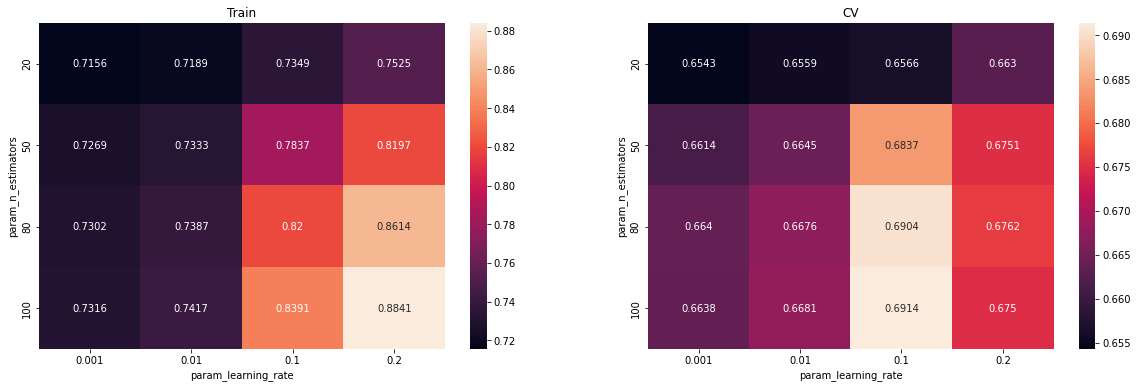

CPU times: user 26.9 s, sys: 603 ms, total: 27.5 s
Wall time: 5min 37s


In [79]:
%%time 
# it will take around 0 minutes also

from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

gbdt = XGBClassifier(max_depth = 3, colsample_bytree = 0.5,subsample = 0.5)

grid_params = {'n_estimators': [20,50,80,100], 'learning_rate' : [0.001, 0.01, 0.1, 0.2]}
 
clf = GridSearchCV(gbdt,grid_params ,cv = 2, scoring = 'roc_auc',n_jobs =-1,verbose = 2,return_train_score =  True)
clf.fit(X_tr, y_train)  

results = pd.DataFrame.from_dict(clf.cv_results_)

results.head(3)

pivoted_results = results.pivot(index = 'param_n_estimators', columns = 'param_learning_rate')

# pivoted_results.head()

fig, ax = plt.subplots(1,2, figsize=(20,6))

sns.heatmap(pivoted_results.mean_train_score, annot = True, fmt='.4g',  ax = ax[0]) 
sns.heatmap(pivoted_results.mean_test_score,  annot = True, fmt='.4g',  ax = ax[1])

ax[0].set_title('Train')
ax[1].set_title('CV')

plt.show()

In [80]:
print('Best ROC-AUC score: ',clf.best_score_)
print('Best Parameter are: ',clf.best_params_)

Best ROC-AUC score:  0.6914018287248757
Best Parameter are:  {'learning_rate': 0.1, 'n_estimators': 100}


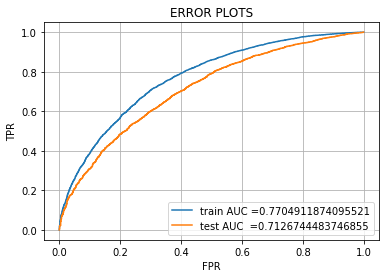

In [81]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc

gbdt = XGBClassifier(n_estimators = 80,max_depth = 3, colsample_bytree = 0.5,subsample = 0.5)
gbdt.fit(X_tr, y_train)

y_train_pred = gbdt.predict_proba(X_tr)[:,1]
y_test_pred  = gbdt.predict_proba(X_te)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr,  test_tpr, te_thresholds  = roc_curve(y_test,  y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr,   label="test AUC  ="+str(auc(test_fpr, test_tpr)))

plt.legend()

plt.xlabel("FPR")
plt.ylabel("TPR")

plt.title("ERROR PLOTS")

plt.grid()
plt.show()

In [82]:
def find_best_threshold(threshold, fpr, tpr):
    t = threshold[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    
    return t

def predict_with_best_t(proba, threshold):
    predictions = []
    
    for i in proba:
        if i>= threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

from sklearn.metrics import confusion_matrix

best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)

the maximum value of tpr*(1-fpr) 0.495656631904913 for threshold 0.832


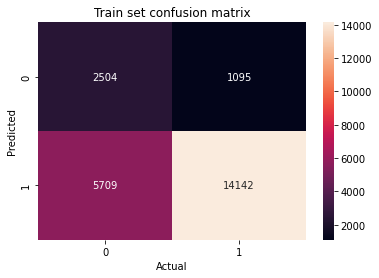

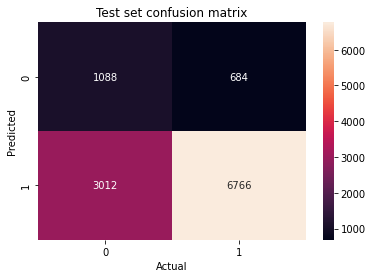

In [83]:
# Heatmap for train set confusion matrix()

heatmap_train = sns.heatmap(confusion_matrix(y_train, predict_with_best_t(y_train_pred,best_t)), annot = True, fmt = "d")

plt.title("Train set confusion matrix")

plt.xlabel("Actual")
plt.ylabel("Predicted")

plt.show()

# Heatmap for test set confusion matrix()

heatmap_test = sns.heatmap(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)), annot = True, fmt = "d")

plt.title("Test set confusion matrix")

plt.xlabel("Actual")
plt.ylabel("Predicted")

plt.show()

<h1>3. Summary</h1>

<br> as mentioned in the step 4 of instructions

In [88]:
from prettytable import PrettyTable
    
x = PrettyTable()
x.field_names = ["Vectorizer", "Model","Max Depth", "n_estimators","Learning Rate", "Train-AUC",'Test-AUC']

x.add_row(["TF-IDf", "XGBOOST",7, 100,'default',1.0,0.6196])
x.add_row(["TF-IDf", "XGBOOST",3, 100,'0.1', 0.79,0.71])

x.add_row(["TF-IDF weighted word2vec", "XGBOOST",  13, 150,'default', 1.0,0.6211])
x.add_row(["TF-IDF weighted word2vec", "XGBOOST",  3, 80,'0.1', 0.77,0.72])

print(x)

+--------------------------+---------+-----------+--------------+---------------+-----------+----------+
|        Vectorizer        |  Model  | Max Depth | n_estimators | Learning Rate | Train-AUC | Test-AUC |
+--------------------------+---------+-----------+--------------+---------------+-----------+----------+
|          TF-IDf          | XGBOOST |     7     |     100      |    default    |    1.0    |  0.6196  |
|          TF-IDf          | XGBOOST |     3     |     100      |      0.1      |    0.79   |   0.71   |
| TF-IDF weighted word2vec | XGBOOST |     13    |     150      |    default    |    1.0    |  0.6211  |
| TF-IDF weighted word2vec | XGBOOST |     3     |      80      |      0.1      |    0.77   |   0.72   |
+--------------------------+---------+-----------+--------------+---------------+-----------+----------+
